# ARIMA Forecasting Model

Our goal is to forecast TSLA's stock price. Because forecasting stock prices is an inherently difficult problem, we will begin by using a simple Autoregressive Integrated Moving Average (ARIMA) model to benchmark performance. This should help us gauge how well our more advanced models are fitting.

In [2]:
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

from statsmodels.tsa.arima_model import ARIMA

from sklearn import utils
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
# Read data
tsla_df = pd.read_csv('TSLA_raw.csv', parse_dates=['Date']) 

# Drop unwanted columns and narrow date range
tsla_df = tsla_df[tsla_df['Date'] > datetime(2019, 9, 1)]

# dates df for later use
dates_df = tsla_df[['Date']]
dates_df = dates_df.reset_index(drop=True).reset_index().rename(columns={'index':'Day'})

tsla_df.set_index('Date', inplace=True)
tsla_series = tsla_df['TSLA'].reset_index(drop=True)

Before we begin fitting our ARIMA model, let's first make sure our data is stationary. A stationary time series is  one whose properties do not depend on the time at which the series is observed. In order for our time series to be stationary, it must meet the following criteria:
    - Constant Mean
    - Constant Variance
    - Constant Autocorrelation

Visually, it should resemble a flat looking series, without trend, constant variance over time, a constant autocorrelation structure over time and no periodic fluctuations

We will assess our data by comparing TSLA's stock price with 1st and 2nd order differencing, and analyzing the ACF plots.

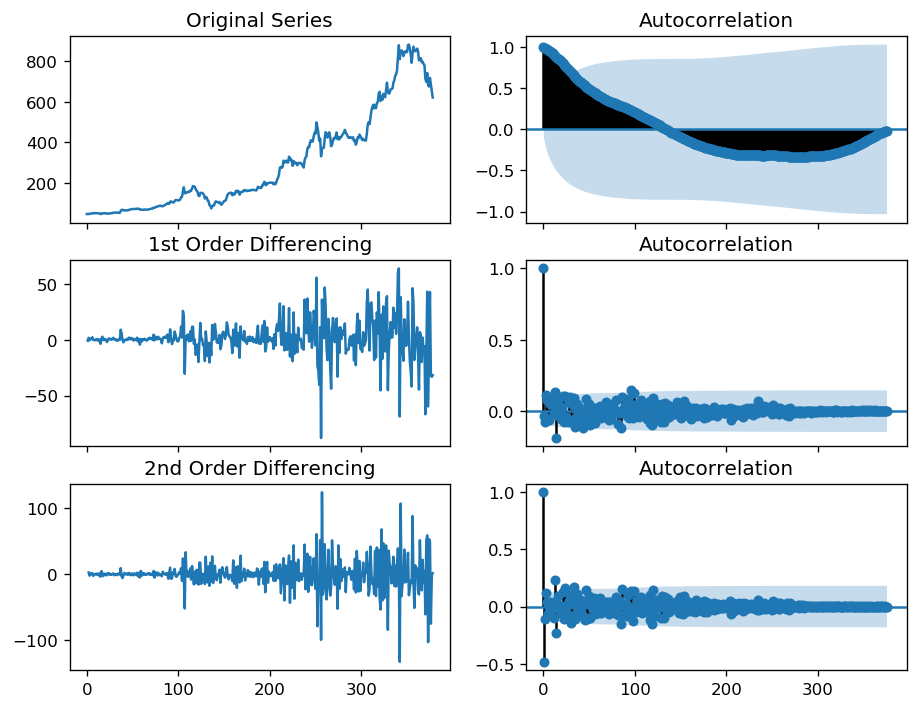

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(tsla_series); axes[0, 0].set_title('Original Series')
plot_acf(tsla_series, ax=axes[0, 1], lags=375)

# 1st Differencing
axes[1, 0].plot(tsla_series.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(tsla_series.diff().dropna(), ax=axes[1, 1], lags=375)

# 2nd Differencing
axes[2, 0].plot(tsla_series.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(tsla_series.diff().diff().dropna(), ax=axes[2, 1], lags=375)

plt.show()

In the original series, we observe a strong upward trend. Differencing the data removes the trend and gives us  a constant mean, which is reflected in our autocorrelation plots. However, there appears to be non-constant variance in both the 1st and 2nd order differenced time series.

To further diagnose this, let's fit a simple (1, 1, 1) ARIMA model to the data and see how it performs.

In [6]:
model = ARIMA(tsla_series.diff().dropna().reset_index(drop=True), order=(1,1,1))
model_fit = model.fit()

Text(0.5, 1.0, 'ARIMA(1,1,1) Residuals')

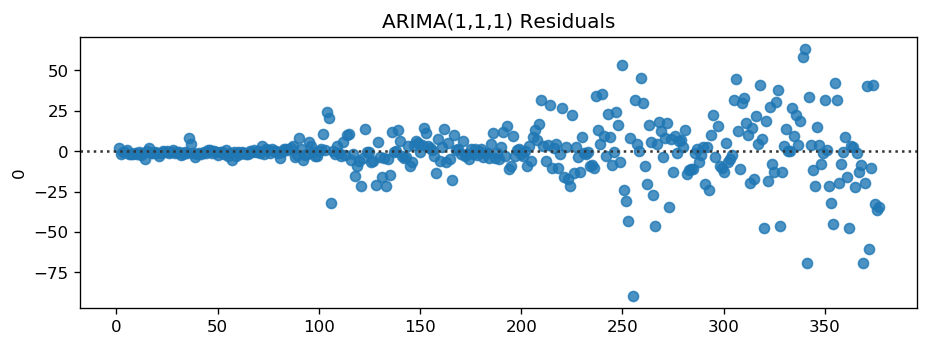

In [7]:
# Residuals
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
residuals = pd.DataFrame(model_fit.resid)
#residuals.plot()
sns.residplot(residuals.index, residuals)
plt.title('ARIMA(1,1,1) Residuals')

As suspected, we observe significant heteroskedasticity in our model, and we can confirm this statistically with the Breusch-Pagan Test. The McLeod Li test would also be appropriate, but is not available in python.

In [8]:
from statsmodels.stats.diagnostic import het_breuschpagan
lagrange_mult, lagrange_p, fstat, fstat_p = het_breuschpagan(residuals.values, np.reshape(residuals.index.values, (-1, 1)))
print(f"Lagrange Multiplier Statistic: {lagrange_mult}")
print(f"F-statistic: {fstat}")
print(f"p-value of F-statistic: {fstat_p}")

Lagrange Multiplier Statistic: 86.57084971712851
F-statistic: 112.07772863686974
p-value of F-statistic: 4.257492071657289e-23


The p-value for the f-statistic is extremely significant, indicating we should reject the null hypothesis that the error variance does not depend on x (time). This confirms that heteroskedasticity is indeed present in our model residuals. In order to handle this, we need to log-transform our data. This should make our variance constant by changing the nature of the data from absolute change to relative change. Let's see how it impacts the data.

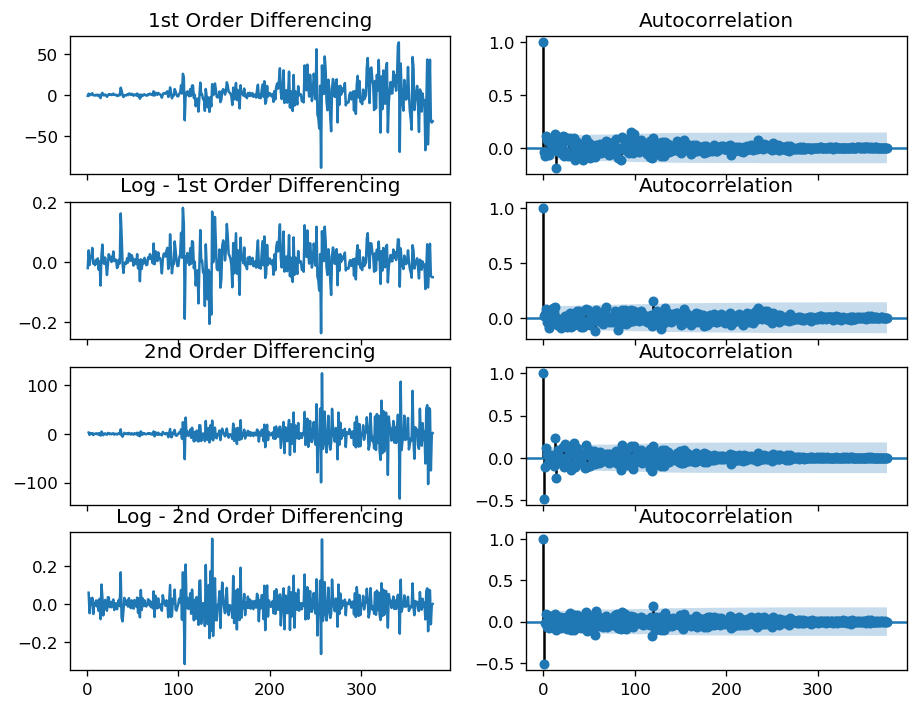

In [9]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# 1st Differencing
fig, axes = plt.subplots(4, 2, sharex=True)
axes[0, 0].plot(tsla_series.diff()); axes[0, 0].set_title('1st Order Differencing')
plot_acf(tsla_series.diff().dropna(), ax=axes[0, 1], lags=375)

# Log - 1st Differencing
axes[1, 0].plot(np.log(tsla_series).diff()); axes[1, 0].set_title('Log - 1st Order Differencing')
plot_acf(np.log(tsla_series).diff().dropna(), ax=axes[1, 1], lags=375)

# 2nd Differencing
axes[2, 0].plot(tsla_series.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(tsla_series.diff().diff().dropna(), ax=axes[2, 1], lags=375)

# Log - 2nd Differencing
axes[3, 0].plot(np.log(tsla_series).diff().diff()); axes[3, 0].set_title('Log - 2nd Order Differencing')
plot_acf(np.log(tsla_series).diff().diff().dropna(), ax=axes[3, 1], lags=375)

plt.show()

There are a few significant lags in the data, but overall the log-transformed 2nd-order differenced data resembles white-noise and we can conclude it is weakly stationary. The next step is to select the order for our Autoregressive and Moving Average terms.

We will use the PACF plot to determine the AR term and ACF to determine the MA term.

C:\Users\joshb\.conda\envs\LSTM\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


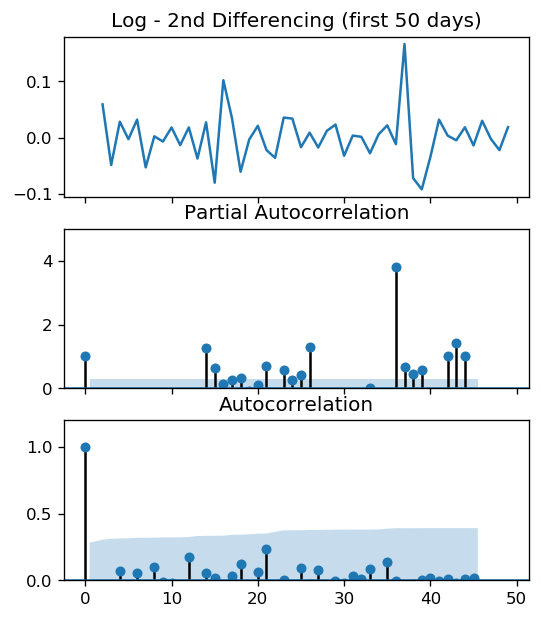

In [10]:
# Determining AR term (p)
plt.rcParams.update({'figure.figsize':(5,6), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 1, sharex=True)


axes[0].plot(np.log(tsla_series[:50]).diff().diff().dropna()); axes[0].set_title('Log - 2nd Differencing (first 50 days)')
axes[1].set(ylim=(0,5))
plot_pacf(np.log(tsla_series[:50]).diff().diff().dropna(), ax=axes[1], lags=45)
axes[2].set(ylim=(0,1.2))
plot_acf(np.log(tsla_series[:50]).diff().diff().dropna(), ax=axes[2], lags=45)

plt.show()

The are very large spikes in some of the lags in the PACF plot, indicating that correlation between observations and their lags is still existing in the data. Because we are using ARIMA as our benchmark model and intend to outperform it with more advanced machine learning algorithms, we are going to accept this and train a model of (1,2,0) using the log-transformed data.

In [11]:
model = ARIMA(np.log(tsla_series[:350]).reset_index(drop=True), order=(1,2,0))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D2.TSLA   No. Observations:                  348
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 479.213
Method:                       css-mle   S.D. of innovations              0.061
Date:                Sat, 20 Mar 2021   AIC                           -952.427
Time:                        11:53:38   BIC                           -940.870
Sample:                             2   HQIC                          -947.826
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -7.46e-06      0.002     -0.003      0.997      -0.004       0.004
ar.L1.D2.TSLA    -0.5195      0.046    -11.367      0.000      -0.609      -0.430
                                    Root

Text(0.5, 1.0, 'ARIMA(1,2,0) Residuals')

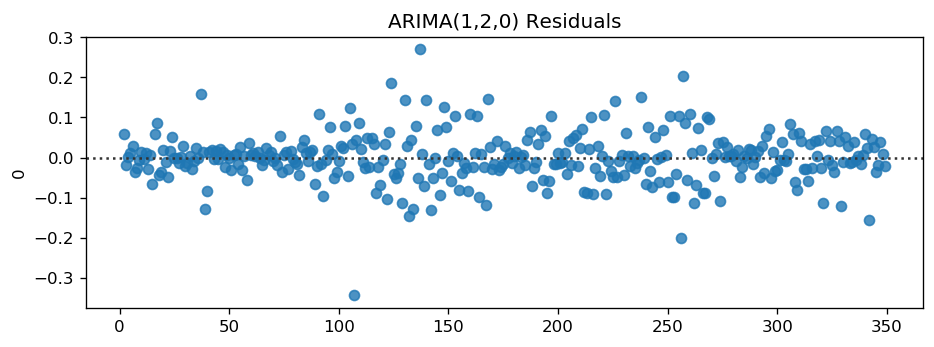

In [12]:
# Residuals
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
residuals = pd.DataFrame(model_fit.resid)
#residuals.plot()
sns.residplot(residuals.index, residuals)
plt.title('ARIMA(1,2,0) Residuals')

Now we observe residuals with a more constant variance, although there are some outliers. There still appears to be some heteroskedasticity present, but it is not heavily skewed like before. Let's go ahead and test our model using the final month of data as our hold-out set. We will predict one day ahead and walk forward, retraining our model with the data available for each new prediction. 

In [14]:
# Forecasting last month of data
training_size = 350
X = np.log(tsla_series).reset_index(drop=True)
train, test = X[0:training_size], X[training_size:len(X)]
history = [x for x in train]
model = ARIMA(train, order=(1,2,0))
model_fit = model.fit()
train_pred = model_fit.predict(start=2, end=training_size-1)
test_pred = []
# walk-forward predictions
for t in range(len(test)):
    model = ARIMA(history, order=(1,2,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    test_pred.append(yhat)
    obs = test[training_size+t]
    history.append(obs)
rmse = math.sqrt(mean_squared_error(test, test_pred))
print(f"Test RMSE: {round(rmse, 3)}")

Test RMSE: 0.053


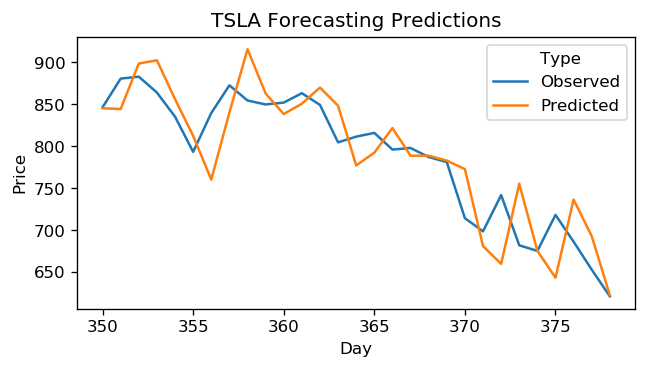

In [15]:
plt.rcParams.update({'figure.figsize':(6,3), 'figure.dpi':120})

# Convert transformed values back to price
test_obs = test.apply(lambda x: np.exp(x))
test_pred = pd.Series(test_pred)
test_pred = test_pred.apply(lambda x: np.exp(x)) 
test_pred = [i[0] for i in test_pred]
test_pred = pd.Series(test_pred)
test_pred.index = range(350, 379)

# Create dataframes and append for visualization
test_obs_df = pd.DataFrame({'Day':test_obs.index, 'Price': test_obs.values})
test_obs_df['Type'] = 'Observed'

test_pred_df = pd.DataFrame({'Day':test_pred.index, 'Price': test_pred})
test_pred_df['Type'] = 'Predicted'

arima_pred = pd.concat([test_obs_df, test_pred_df], ignore_index=True, sort=False)

# Plot
sns.lineplot(data= arima_pred, x="Day", y="Price", hue="Type")
plt.title("TSLA Forecasting Predictions")
plt.show()

Our benchmark score is an RMSE = 0.053